## [통계적머신러닝] 과제9
통계학과 2019150419 기다연<br>
2021.10.26

### 문제1.
Wine data를 이용하여 logistic, SVM, CART 모형을 적합하되 nested cross validation을 적용해 최선의 모형을 산출하라.

In [12]:
# wine data 불러오기 (12개의 특성변수 존재)
import pandas as pd
import numpy as np

dat_wine=pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                     'wine/wine.data',header=None)
dat_wine.head()
dat_wine.columns = ['class label', 'alchohol', 'malic acid', 'ash', 
                    'alcalinity of ash', 'magnesium', 'total phenols', 
                    'flavanoids', 'nonflavanoid phenols', 
                    'proanthocyanins', 'color intensity', 'hue', 
                    'OD208', 'proline']  # Column names
print('class label:', np.unique(dat_wine['class label']))  # Class 출력
dat_wine.head()

class label: [1 2 3]


,class label,alchohol,malic acid,ash,alcalinity of ash,magnesium,total phenols,flavanoids,nonflavanoid phenols,proanthocyanins,color intensity,hue,OD208,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [13]:
from sklearn.model_selection import train_test_split
X,y=dat_wine.iloc[:,1:].values, dat_wine.iloc[:,0].values

# 단위에 따라 예민하는 PCA이므로, 변수들을 잘 측정하고 PCA의 accuracy를 높이기 위해서는 Scaling 작업을 해준다.
# Scaling을 해줌으로써 단위를 맞추게 되고, PCA의 성능이 높아진다.
from sklearn.preprocessing import StandardScaler
std=StandardScaler()
X_std=std.fit_transform(X)

In [14]:
X.shape

(178, 13)

In [15]:
y.shape

(178,)

In [16]:
X_std.shape # 정규화 시킨 X

(178, 13)

In [17]:
# train-test dataset 분할
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2)
print(X_train.shape, X_test.shape)

(142, 13) (36, 13)


In [18]:
# library import
from sklearn.pipeline import make_pipeline
import scipy as sp
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

# About cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

### 0. Baseline

In [19]:
# Baseline accruacy without any GridSearchCV/Nested CV
model = SVC()
model.fit(X_train, y_train)
print('SVM score : %s' % model.score(X_test, y_test))

model = LogisticRegression()
model.fit(X_train, y_train)
print('Logistic score : %s' % model.score(X_test, y_test))

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
print('CART score : %s' % model.score(X_test, y_test))

SVM score : 0.9722222222222222
Logistic score : 0.9722222222222222
CART score : 0.8611111111111112


In [21]:
# model별 param grid 설정
logit_params = {'penalty': ['l2', 'l1', 'elasticnet', None],
                'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 15, 20], 
                'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                'multi_class':['auto', 'ovr', 'multinomial'],
                }

svc_params = {'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 15, 20, 100], 
              'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma':[0.0001, 0.001, 0.01, 0.1, 1, 10, 15, 20, 100]
             }

tree_params = {'criterion':['gini', 'entropy'],
               'splitter':['best', 'random'], 
               'max_depth' :list((range(0, 15))), 
               'min_samples_leaf' :list((range(0, 10))), 
               'max_features' : ['auto', 'sqrt', 'log2', None],
               'ccp_alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 15, 20], 
                }

In [22]:
# 10*5 nested cross validation
inner_cv = KFold(n_splits = 3, shuffle=True, random_state=0) # 초모수 세팅
outer_cv = KFold(n_splits = 5, shuffle=True, random_state=0) # 성능 평가

### 1. Logistic

In [23]:
%%time
pipe_log = make_pipeline(StandardScaler(), 
                         LogisticRegression(random_state=1))

gs_l = GridSearchCV(estimator=pipe_log, 
                    param_grid=logit_params,
                    scoring='accuracy', 
                    cv=outer_cv, 
                    n_jobs=-1)
scores_l = cross_val_score(gs_l, X_std, y, scoring='accuracy', cv=inner_cv)
print('Nested CV accuracy(Logistic Regression): %.3f +/- %.3f' % (np.mean(scores_l), np.std(scores_l)))

Nested CV accuracy(Logistic Regression): nan +/- nan
CPU times: user 199 ms, sys: 287 ms, total: 486 ms
Wall time: 3.33 s


### 2. SVM

In [63]:
%%time
pipe_svm = make_pipeline(StandardScaler(), 
                         SVC(random_state=1))

gs_2 = GridSearchCV(estimator=pipe_svm, 
                    param_grid=svc_params,
                    scoring='accuracy', 
                    cv=outer_cv, 
                    n_jobs=-1)
scores_2 = cross_val_score(gs_2, X, y, scoring='accuracy', cv=inner_cv)
print('Nested CV accuracy(SVM): %.3f +/- %.3f' % (np.mean(scores_2), np.std(scores_2)))

Nested CV accuracy(SVM): nan +/- nan
CPU times: user 165 ms, sys: 275 ms, total: 440 ms
Wall time: 3.31 s


### 3. CART

In [72]:
%%time
pipe_tree = make_pipeline(StandardScaler(), 
                         DecisionTreeClassifier(random_state=1))

gs_3 = GridSearchCV(estimator=pipe_tree, 
                    param_grid=svc_params,
                    scoring='accuracy', 
                    cv=outer_cv, 
                    n_jobs=-1)
scores_3 = cross_val_score(gs_2, X, y, scoring='accuracy', cv=inner_cv)
print('Nested CV accuracy(DecisionTree): %.3f +/- %.3f' % (np.mean(scores_3), np.std(scores_3)))

Nested CV accuracy(DecisionTree): nan +/- nan
CPU times: user 157 ms, sys: 281 ms, total: 437 ms
Wall time: 3.56 s


SVM이 최선의 모형인 것을 알 수 있었으며, 다시 SVM을 fit해주었다.

In [24]:
gs_s = GridSearchCV(estimator=SVC(random_state=1), 
                  param_grid=svc_params,
                  scoring='accuracy', cv=inner_cv, n_jobs=-1)
gs_s.fit(X_train, y_train)
gs_s

GridSearchCV(cv=KFold(n_splits=3, random_state=0, shuffle=True),
             estimator=SVC(random_state=1), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 15, 20, 100],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 15, 20,
                                   100],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

In [25]:
print(gs_s.best_params_)
print(gs_s.best_score_)

{'C': 0.01, 'gamma': 0.0001, 'kernel': 'linear'}
0.9930555555555555


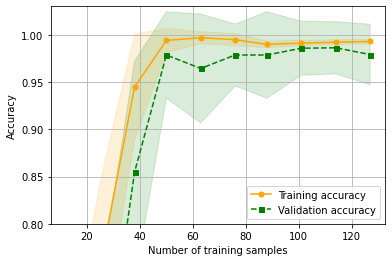

In [26]:
# Bias-variance trade-off 그래프로 확인
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(),
                        SVC(C=0.01, gamma=0.0001, kernel='linear'))
train_sizes, train_scores, test_scores =\
             learning_curve(estimator=pipe_lr, 
                            X=X_train, 
                            y=y_train,
                            train_sizes=np.linspace(0.1, 1.0, 10),  # 균등하게 10등분으로 분할
                            cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(train_sizes, train_mean, color='orange', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='orange')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])

plt.show()

# 과대/과소적합이 발생하고 있지 않음.